# EfficientNet training on Tiny ImageNet
the goal of this notebook is to train the EfficientNet model on the Tiny ImageNet dataset. 

- EfficientNet Model implementation: 
    - [Machine-Learning-Collection](https://github.com/aladdinpersson/Machine-Learning-Collection/tree/master)
    - [EfficientNet-PyTorch](https://github.com/lukemelas/EfficientNet-PyTorch/tree/master)

- Tiny imagenet dataset - from 

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
# Import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dt

import torch
from torch import optim, nn
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision.utils import make_grid
from torchvision import models, datasets
from torchvision import transforms as T

import os
from random import randint
import urllib
import zipfile

# Define device to use (CPU or GPU). CUDA = GPU support for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print("Device to use:", device)


Matplotlib created a temporary cache directory at /tmp/matplotlib-eljibcb3 because the default path (/home/guy/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device to use: cuda:0


In [3]:
DATA_DIR = '/datasets/vision/tiny-imagenet-200' # Original images come in shapes of [3,64,64]
# Define training and validation data paths
TRAIN_DIR = os.path.join(DATA_DIR, 'train') 
VALID_DIR = os.path.join(DATA_DIR, 'val')

### Setup helper functions
Taken from [this notebook](https://github.com/kennethleungty/PyTorch-Ignite-Tiny-ImageNet-Classification/blob/main/Tiny_ImageNet_Classification.ipynb)

In [4]:
# Functions to display single or a batch of sample images
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
def show_batch(dataloader):
    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    imshow(make_grid(images)) # Using Torchvision.utils make_grid function
    
def show_image(dataloader):
    dataiter = iter(dataloader)
    images, labels = dataiter.next()
    random_num = randint(0, len(images)-1)
    imshow(images[random_num])
    label = labels[random_num]
    print(f'Label: {label}, Shape: {images[random_num].shape}')

# Setup function to create dataloaders for image datasets
def generate_dataloader(data, name, transform, batch_size=32):
    if data is None: 
        return None
    
    # Read image files to pytorch dataset using ImageFolder, a generic data 
    # loader where images are in format root/label/filename
    # See https://pytorch.org/vision/stable/datasets.html
    if transform is None:
        dataset = datasets.ImageFolder(data, transform=T.ToTensor())
    else:
        dataset = datasets.ImageFolder(data, transform=transform)

    # Set options for device
    if use_cuda:
        kwargs = {"pin_memory": True, "num_workers": 1}
    else:
        kwargs = {}
    
    # Wrap image dataset (defined above) in dataloader 
    dataloader = DataLoader(dataset, batch_size=batch_size, 
                        shuffle=(name=="train"), 
                        **kwargs)
    
    return dataloader

### Organize validation folder
should be run if the validation folder is not present


In [ ]:
# Unlike training folder where images are already arranged in sub folders based 
# on their labels, images in validation folder are all inside a single folder. 
# Validation folder comes with images folder and val_annotations txt file. 
# The val_annotation txt file comprises 6 tab separated columns of filename, 
# class label, x and y coordinates, height, and width of bounding boxes
val_data = pd.read_csv(f'{VALID_DIR}/val_annotations.txt', 
                       sep='\t', 
                       header=None, 
                       names=['File', 'Class', 'X', 'Y', 'H', 'W'])

# val_data.head()

In [5]:
# Create separate validation subfolders for the validation images based on
# their labels indicated in the val_annotations txt file
val_img_dir = os.path.join(VALID_DIR, 'images')

# Open and read val annotations text file
fp = open(os.path.join(VALID_DIR, 'val_annotations.txt'), 'r')
data = fp.readlines()

# Create dictionary to store img filename (word 0) and corresponding
# label (word 1) for every line in the txt file (as key value pair)
val_img_dict = {}
for line in data:
    words = line.split('\t')
    val_img_dict[words[0]] = words[1]
fp.close()

# Display first 10 entries of resulting val_img_dict dictionary
{k: val_img_dict[k] for k in list(val_img_dict)[:10]}

{'val_0.JPEG': 'n03444034',
 'val_1.JPEG': 'n04067472',
 'val_2.JPEG': 'n04070727',
 'val_3.JPEG': 'n02808440',
 'val_4.JPEG': 'n02808440',
 'val_5.JPEG': 'n04399382',
 'val_6.JPEG': 'n04179913',
 'val_7.JPEG': 'n02823428',
 'val_8.JPEG': 'n04146614',
 'val_9.JPEG': 'n02226429'}

In [8]:
# check if the elements in os.listdir(val_img_dir) are folders
val_img_dir = '/datasets/vision/tst/tiny-imagenet-200/val/images'
len([d for d in os.listdir(val_img_dir) if os.path.isdir(os.path.join(val_img_dir, d))])

0

In [ ]:
# Create subfolders (if not present) for validation images based on label ,
# and move images into the respective folders
for img, folder in val_img_dict.items():
    newpath = (os.path.join(val_img_dir, folder))
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    if os.path.exists(os.path.join(val_img_dir, img)):
        os.rename(os.path.join(val_img_dir, img), os.path.join(newpath, img))

In [ ]:
# Save class names (for corresponding labels) as dict from words.txt file
class_to_name_dict = dict()
fp = open(os.path.join(DATA_DIR, 'words.txt'), 'r')
data = fp.readlines()
for line in data:
    words = line.strip('\n').split('\t')
    class_to_name_dict[words[0]] = words[1].split(',')[0]
fp.close()

# Display first 20 entries of resulting dictionary
{k: class_to_name_dict[k] for k in list(class_to_name_dict)[:20]}

### calculate training data statistics
to be used for image normalization if training from scratch.  
The result should be:
```
Mean: tensor([0.4802, 0.4481, 0.3975]), Std: tensor([0.2296, 0.2263, 0.2255])
```

In [ ]:
# collect statistics for the training data
def calculate_mean_std(loader):
    mean = 0.0
    std = 0.0
    total_images_count = 0
    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += batch_samples
    mean /= total_images_count
    std /= total_images_count
    return mean, std

In [ ]:
train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=T.Compose([T.ToTensor()]))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)

In [ ]:
mean, std = calculate_mean_std(train_loader)
print(f'Mean: {mean}, Std: {std}')

## Preparing Data loaders

### Define Image Pre-processing Transformations
PyTorch transforms define image transformations that convert all images in dataset into a standardized format.



In [23]:
# Define transformation sequence for image pre-processing
# If not using pre-trained model, normalize with 0.5, 0.5, 0.5 (mean and SD)
# If using pre-trained ImageNet, normalize with mean=[0.485, 0.456, 0.406], 
# std=[0.229, 0.224, 0.225])
trn_mean=[0.4802, 0.4481, 0.3975]
trn_std=[0.2296, 0.2263, 0.2255]

preprocess_transform = T.Compose([
                T.Resize(256), # Resize images to 256 x 256
                T.CenterCrop(224), # Center crop image
                T.RandomHorizontalFlip(),
                T.ToTensor(),  # Converting cropped images to tensors
                T.Normalize(mean=trn_mean, std=trn_std)  
])

preprocess_transform_pretrain = T.Compose([
                T.Resize(256), # Resize images to 256 x 256
                T.CenterCrop(224), # Center crop image
                T.RandomHorizontalFlip(),
                T.ToTensor(),  # Converting cropped images to tensors
                T.Normalize(mean=[0.485, 0.456, 0.406], 
                            std=[0.229, 0.224, 0.225])
])

In [26]:
normalize = T.Compose([T.ToTensor(), T.Normalize(mean=trn_mean, std=trn_std)])
normalize_lambda = T.Lambda(lambda x: normalize(x[0]))

preprocess_transform = T.Compose([
                T.Resize(256), # Resize images to 256 x 256
                # T.CenterCrop(224), # Center crop image
                # T.RandomHorizontalFlip(),
                T.TenCrop(224),
                normalize_lambda
])




### create data loaders

#### train dataloader

In [27]:
# Define batch size for data loaders
batch_size = 64

train_loader = generate_dataloader(TRAIN_DIR, "train",
                                  transform=preprocess_transform,
                                  batch_size=batch_size)

In [28]:
# Display batch of training set images
# show_batch(train_loader)
imgs,lbls = next(iter(train_loader))
imgs.shape

torch.Size([64, 3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


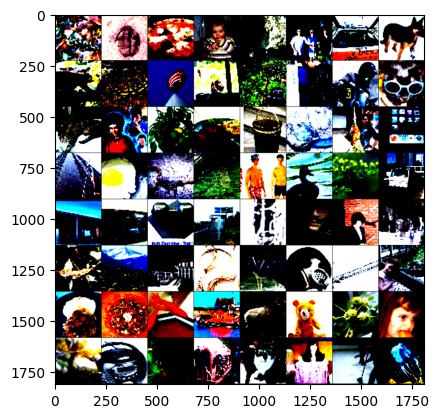

In [29]:
imshow(make_grid(imgs))

#### Validation set dataloader

In [ ]:
# Create dataloaders for validation data (depending if model is pretrained)
val_loader = generate_dataloader(VALID_DIR, "val",
                                 transform=preprocess_transform)


In [ ]:
show_batch(val_loader)

## Building and training the model
we'll be using the [Efficient-PyTorch](https://github.com/lukemelas/EfficientNet-PyTorch/tree/master) implementation of the EfficientNet model. and [Pytorch-lightning](https://lightning.ai/docs/pytorch/stable/) for training. 

### Defining the model
I've copied the code from the Efficient-PyTorch implementation and saved it in the `efficientnet_pytorch` folder.

In [ ]:
from efficientnet_pytorch import EfficientNet
CHECKPOINT_PATH = "saved_models"

In [ ]:
model = EfficientNet.from_name('efficientnet-b0', num_classes=200)
model

In [ ]:
# get the number of parameters in the model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

### Pytorch Lightning Module definition
We'll be using the pytorch lightning library to train the model.  
There are 2 references to follow:
- [Pytorch Lightning tutorial 4](https://lightning.ai/docs/pytorch/stable/notebooks/course_UvA-DL/04-inception-resnet-densenet.html)
- [Image Classification using PTL and W&B](https://wandb.ai/wandb/wandb-lightning/reports/Image-Classification-Using-PyTorch-Lightning-and-Weights-Biases--VmlldzoyODk1NzY)

following their [tutorial 4](https://lightning.ai/docs/pytorch/stable/notebooks/course_UvA-DL/04-inception-resnet-densenet.html)
we need to define 2 main modules:
- TinyImageNetModule (LightningModule)
- Trainer


In [ ]:
import lightning as L
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger, WandbLogger
L.seed_everything(42)

In [ ]:
model_dict = {}

def create_model(model_name, model_hparams):
    if model_name in model_dict:
        return model_dict[model_name](**model_hparams)
    else:
        assert False, f'Unknown model name "{model_name}". Available models are: {str(model_dict.keys())}'

def create_efficientnet_model(model_name, model_hparams):
    load_pretrained = model_hparams.pop('load_pretrained', False)
    if load_pretrained:
        model = EfficientNet.from_pretrained(model_name, **model_hparams)
    else:
        model = EfficientNet.from_name(model_name, **model_hparams)
    return model

model_hparams = {'load_pretrained': False, 'num_classes': 200}


In [ ]:
class TinyImageNetModule(L.LightningModule):
    def __init__(self, model_name, model_hparams, optimizer_name, optimizer_hparams):
        """TinyImageNetModule.

        Args:
            model_name: Name of the model/CNN to run. Used for creating the model (see function below)
            model_hparams: Hyperparameters for the model, as dictionary.
            optimizer_name: Name of the optimizer to use. Currently supported: Adam, SGD
            optimizer_hparams: Hyperparameters for the optimizer, as dictionary. This includes learning rate, weight decay, etc.
        """
        super().__init__()
        # Exports the hyperparameters to a YAML file, and create "self.hparams" namespace
        self.save_hyperparameters()
        # Create model
        self.model = create_efficientnet_model(model_name, model_hparams)
        # Create loss module
        self.loss_module = nn.CrossEntropyLoss()
        # Example input for visualizing the graph in Tensorboard
        self.example_input_array = torch.zeros((1, 3, 224, 224), dtype=torch.float32)

    def forward(self, imgs):
        # Forward function that is run when visualizing the graph
        return self.model(imgs)

    def configure_optimizers(self):
        # We will support Adam or SGD as optimizers.
        if self.hparams.optimizer_name == "Adam":
            # AdamW is Adam with a correct implementation of weight decay (see here
            # for details: https://arxiv.org/pdf/1711.05101.pdf)
            optimizer = optim.AdamW(self.parameters(), **self.hparams.optimizer_hparams)
        elif self.hparams.optimizer_name == "SGD":
            optimizer = optim.SGD(self.parameters(), **self.hparams.optimizer_hparams)
        elif self.hparams.optimizer_name == "RMSprop":
            optimizer = optim.RMSprop(self.parameters(), **self.hparams.optimizer_hparams)
        else:
            assert False, f'Unknown optimizer: "{self.hparams.optimizer_name}"'

        # We will reduce the learning rate by 0.1 after 100 and 150 epochs
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 150], gamma=0.1)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        # "batch" is the output of the training data loader.
        imgs, labels = batch
        preds = self.model(imgs)
        loss = self.loss_module(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        # Logs the accuracy per epoch to tensorboard (weighted average over batches)
        self.log("train_acc", acc, on_step=False, on_epoch=True)
        self.log("train_loss", loss)
        return loss  # Return tensor to call ".backward" on

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)
        acc = (labels == preds).float().mean()
        # By default logs it per epoch (weighted average over batches)
        self.log("val_acc", acc)

    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)
        acc = (labels == preds).float().mean()
        # By default logs it per epoch (weighted average over batches), and returns it afterwards
        self.log("test_acc", acc)

In [ ]:
import wandb
wandb.login()

In [ ]:
def train_model(model_name, trainer_params, save_name=None, eval_only=False,**kwargs):
    """Train model.

    Args:
        model_name: Name of the model you want to run. Is used to look up the class in "model_dict"
        save_name (optional): If specified, this name will be used for creating the checkpoint and logging directory.
    """
    save_name = model_name+save_name

    # add wandb logger
    wandb_logger = WandbLogger(name=save_name, project="tiny-imagenet")

    # Create a PyTorch Lightning trainer with the generation callback
    trainer = L.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, save_name),  # Where to save models and tensorboard logs
        # We run on a single GPU (if possible)
        accelerator="auto",
        # devices=trainer_params['devices'],
        # strategy=trainer_params['strategy'],
        # # How many epochs to train for if no patience is set
        # max_epochs=trainer_params["max_epochs"],
        logger = wandb_logger,
        callbacks=[
            ModelCheckpoint(
                save_weights_only=True, mode="max", monitor="val_acc"
            ),  # Save the best checkpoint based on the maximum val_acc recorded. Saves only weights and not optimizer
            LearningRateMonitor("epoch"),
        ],  # Log learning rate every epoch
        **trainer_params
    )  # In case your notebook crashes due to the progress bar, consider increasing the refresh rate
    trainer.logger._log_graph = True  # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None  # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, save_name + ".ckpt")
    if eval_only and os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        # Automatically loads the model with the saved hyperparameters
        model = TinyImageNetModule.load_from_checkpoint(pretrained_filename)
    else:
        L.seed_everything(42)  # To be reproducible
        model = TinyImageNetModule(model_name=model_name, **kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = TinyImageNetModule.load_from_checkpoint(
            trainer.checkpoint_callback.best_model_path
        )  # Load best checkpoint after training

    # Test best model on validation and test set
    val_result = trainer.test(model, dataloaders=val_loader, verbose=False)
    # test_result = trainer.test(model, dataloaders=test_loader, verbose=False)
    # result = {"test": test_result[0]["test_acc"], "val": val_result[0]["test_acc"]}

    result = {"val": val_result[0]["test_acc"]}
    wandb.finish()
    return model, result

In [ ]:
model_hparams = {'load_pretrained': False, 'num_classes': 200}
optimizer_hparams = {'lr': 0.01, 'weight_decay': 0.0001}
optimizer_name = "RMSprop"
# trainer_params = {'max_epochs': 10,'devices':'auto','strategy':'ddp'}
trainer_params = {'max_epochs': 50,'devices':'auto'}

train_model('efficientnet-b0', trainer_params, save_name='exp2',model_hparams=model_hparams, optimizer_name=optimizer_name, optimizer_hparams=optimizer_hparams)

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir ./saved_models/efficientnet-b0exp1/lightning_logs

In [ ]:
model_dict["EfficientNetb0"] = GoogleNet